##**1. Import Libraries and Setup Kaggle API**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision.models as models
from PIL import Image
import os
import cv2
import random
from glob import glob
import matplotlib.image as mpimg
from torch.optim import lr_scheduler
import time

In [2]:
# Uncoment if you running in Google Colab
#from google.colab import files

#Upload the Kaggle API token (kaggle.json) file
#uploaded = files.upload()

#Move the uploaded file to the required directory
#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Uncoment if you running in Google Colab
# !kaggle datasets download -d xhlulu/140k-real-and-fake-faces

In [4]:
#import zipfile

#Unzip the dataset
#with zipfile.ZipFile('140k-real-and-fake-faces.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/')

##**2. Utility Functions and Dataset Preparation**

In [5]:
from source.utils import display_images, fetch_image_paths_and_labels, display_normalized_images
from source.data_utils import construct_loader, preprocess_data

In [6]:
# Define the directory containing the images
# Google colab paths
#image_dir_train = '/content/real_vs_fake/real-vs-fake/train'
#image_dir_val = '/content/real_vs_fake/real-vs-fake/valid'
#image_dir_test = '/content/real_vs_fake/real-vs-fake/test'

image_dir_train = 'data/real_vs_fake/train'
image_dir_val = 'data/real_vs_fake/valid'
image_dir_test = 'data/real_vs_fake/test'

train_paths, train_labels = fetch_image_paths_and_labels(image_dir_train)
val_paths, val_labels = fetch_image_paths_and_labels(image_dir_val)
test_paths, test_labels = fetch_image_paths_and_labels(image_dir_test)

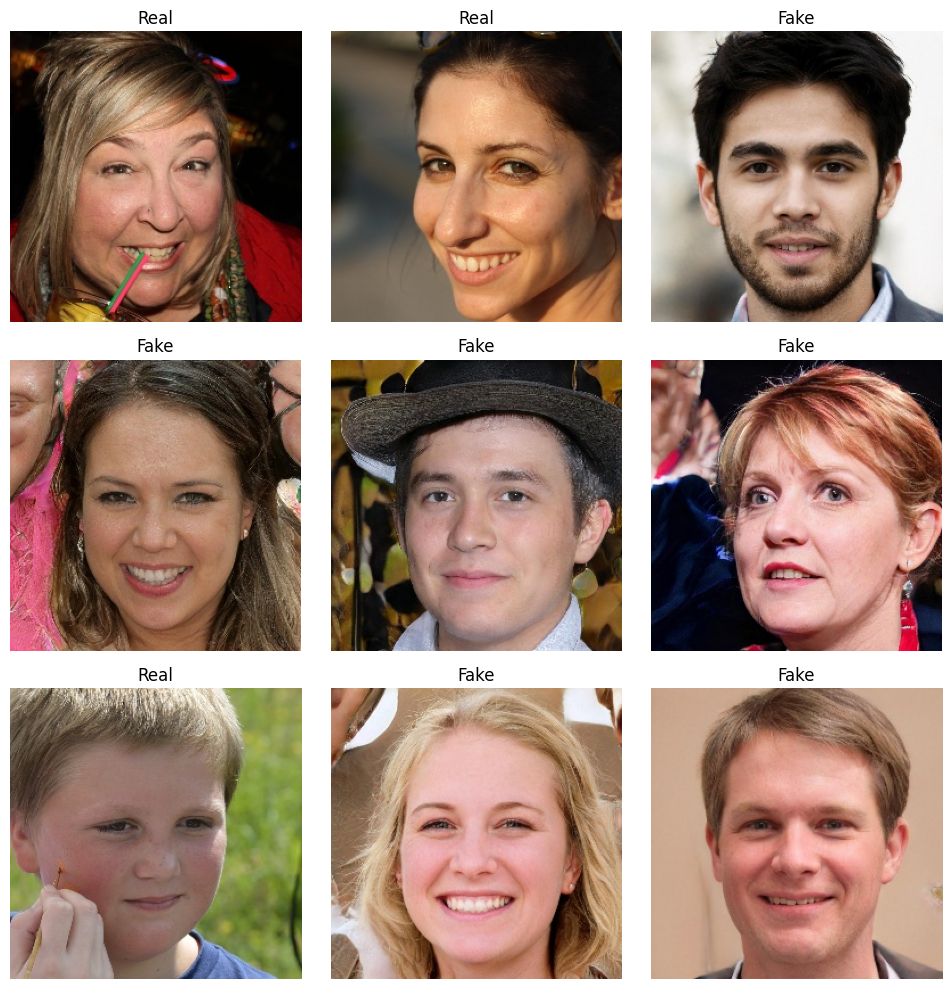

In [7]:
# Display 9 random images in a 3x3 grid
display_images(train_paths[:9], train_labels[:9])
plt.tight_layout()

In [8]:
# Apply transformations and convert to DataLoader format for train and test data
trainloader = construct_loader(train_paths, train_labels, train=True)
validloader = construct_loader(val_paths, val_labels, train=False)
#testloader = construct_loader(test_paths, test_labels, train=False)

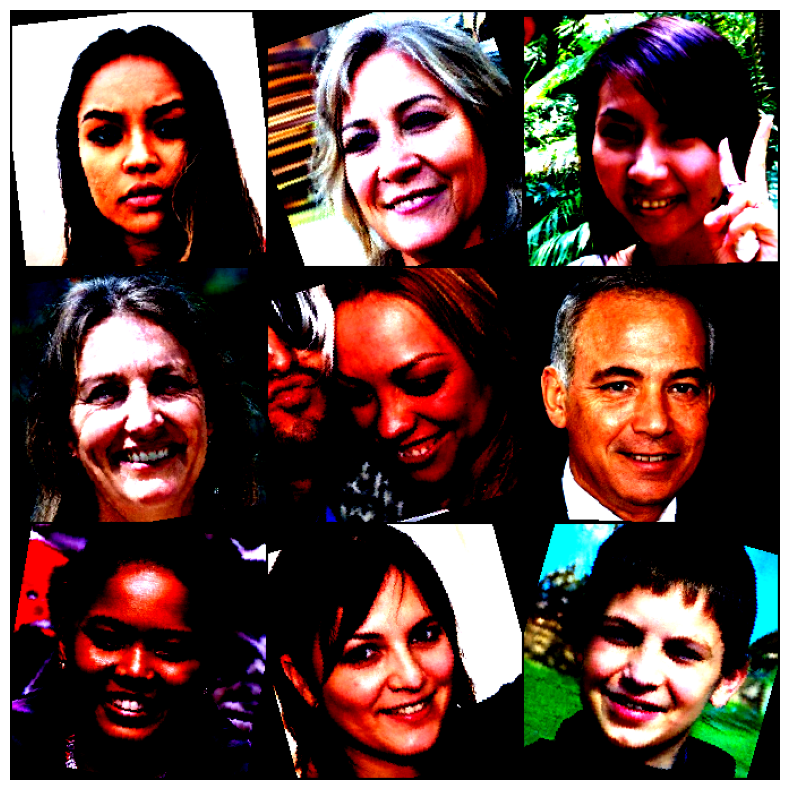

In [9]:
display_normalized_images(trainloader)

##**3. Model Selection**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2  # Assuming binary classification (real vs fake)
batch_size=32
num_epochs=10

# Model
model=models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

In [ ]:
#Create a directory.
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)
create_dir("files")

checkpoint_path = "files/checkpoint.pth"

##**4. Training and Evaluation**

In [ ]:
# Function to train the model and evaluate on test data
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc_train:.4f}')

        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        running_loss_test = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Update statistics
                running_loss_test += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_loss_test = running_loss_test / len(test_loader.dataset)
        epoch_acc_test = correct_test / total_test
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_loss_test:.4f}, Validation Accuracy: {epoch_acc_test:.4f}')

        # Save model checkpoint if validation loss improves
        if epoch_loss_test < best_valid_loss:
            best_valid_loss = epoch_loss_test
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Saving model checkpoint at epoch {epoch+1}')

In [ ]:
train_and_evaluate_model(model, trainloader, validloader, loss_fn, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.5756, Train Accuracy: 0.6901
Epoch [1/10], Validation Loss: 0.5574, Validation Accuracy: 0.7429
Saving model checkpoint at epoch 1
Epoch [2/10], Train Loss: 0.3847, Train Accuracy: 0.8274
Epoch [2/10], Validation Loss: 0.2899, Validation Accuracy: 0.8782
Saving model checkpoint at epoch 2
Epoch [3/10], Train Loss: 0.2720, Train Accuracy: 0.8859
Epoch [3/10], Validation Loss: 0.2539, Validation Accuracy: 0.8942
Saving model checkpoint at epoch 3
Epoch [4/10], Train Loss: 0.2088, Train Accuracy: 0.9150
Epoch [4/10], Validation Loss: 0.2248, Validation Accuracy: 0.9103
Saving model checkpoint at epoch 4
Epoch [5/10], Train Loss: 0.1635, Train Accuracy: 0.9354
Epoch [5/10], Validation Loss: 0.1671, Validation Accuracy: 0.9345
Saving model checkpoint at epoch 5
Epoch [6/10], Train Loss: 0.1334, Train Accuracy: 0.9477
Epoch [6/10], Validation Loss: 0.1318, Validation Accuracy: 0.9460
Saving model checkpoint at epoch 6
Epoch [7/10], Train Loss: 0.1104, Train Accura

## **5. Inference Engine and Evaluation of Saved Model**

In [ ]:
from inference_engine import FaceClassifier

In [ ]:
def evaluate_saved_model(face_classifier, image_paths, image_labels):
    predictions = face_classifier.classify(image_paths, image_labels)

    # Convert image_labels to a tensor
    true_labels = torch.tensor(image_labels, dtype=torch.long)

    # Calculate accuracy
    correct = (torch.tensor(predictions) == true_labels).sum().item()
    total = true_labels.size(0)
    accuracy = correct / total

    # Print accuracy
    print(f'Accuracy: {accuracy:.3f}')

In [ ]:
face_classifier = FaceClassifier(checkpoint_path)
evaluate_saved_model(face_classifier, test_paths, test_labels)

Accuracy: 0.966
